In [31]:
import tarfile
import gzip
import io
import duckdb
import tempfile
import csv
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import json

In [ ]:
tar_path = "/data/cher/user_cher/eBird/ebd_relFeb-2025.tar"

In [ ]:
# What files are associated with sampling dataset?

with tarfile.open(tar_path, "r") as tar:
    # List all member names in the archive
    file_list = tar.getnames()
    
print("Files in the archive:")
for name in file_list:
    print(name)


NOTES:
- Native (NULL) v. Non-native ((N)aturalized, (P)rovisional, (X)scapee) species can be found in EXOTIC CODE. 
- More than 95% of checklists are less than 10 km in length; however, some checklists are as long as 80 km in length. Long traveling checklists have lower spatial precision so they should generally be removed prior to analysis.
- Heavily populated (e.g. cities) or easily accessible areas (e.g. near roads) typically have more detections simply because more people visit them. In contrast, more remote areas may have better habitat for certain species, but have fewer observations because fewer birders are visiting these sites.

In [ ]:
# File paths and filenames
tar_path = "/data/cher/user_cher/eBird/ebd_relFeb-2025.tar"
csv_filename = "ebd_relFeb-2025.txt.gz"

# Step 1: Open the tar archive and extract the gzipped CSV file as a file-like object
with tarfile.open(tar_path, "r") as tar:
    f = tar.extractfile(csv_filename)
    if f is None:
        raise FileNotFoundError(f"{csv_filename} not found in the tar archive.")
    # Open the gzipped file in text mode
    with gzip.open(f, mode='rt') as gz:
        # Read the first 10 lines from the decompressed content
        lines = [next(gz) for _ in range(10)]
        csv_content = "".join(lines)

# Step 2: Write the in-memory CSV content to a temporary file
with tempfile.NamedTemporaryFile(mode="w+", delete=False, suffix=".csv") as tmp:
    tmp.write(csv_content)
    tmp_path = tmp.name

# Step 3: Use DuckDB's SQL interface to read the CSV from the temporary file
query = f"SELECT * FROM read_csv_auto('{tmp_path}') LIMIT 10;"
df = duckdb.query(query).df()

print("First 10 rows:")
print(df)


In [ ]:
# (lon_min, lon_max, lat_min, lat_max).
lon_min, lon_max, lat_min, lat_max = -90.6809899999999942, -90.0909899999996924, 38.4560099999999991, 38.8860099999999136
# Date range for filtering
start_date = datetime(2010, 1, 1)
end_date = datetime(2025, 12, 31)

tar_path = "/data/cher/user_cher/eBird/ebd_sampling_relFeb-2025.tar"
csv_filename = "ebd_sampling_relFeb-2025.txt.gz"
output_filename = "stl_ebird_sampling_data.csv"

In [ ]:
import pandas as pd
df = pd.read_csv('/data/cher/EcoBound/data/eBird/stl_ebird_observations_data.txt', sep='\t', encoding='ascii', on_bad_lines='skip')

In [ ]:
import matplotlib.pyplot as plt

# Count the number of observations per class
class_counts = df['SCIENTIFIC NAME'].value_counts()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(class_counts.values, bins=30, edgecolor='black')
plt.xlabel("Number of Observations per Class")
plt.ylabel("Frequency")
plt.title("Histogram of Observations per Class")
plt.grid(True)
plt.show()


In [ ]:
# Open the tar archive and extract the gzipped CSV file as a file-like object
with tarfile.open(tar_path, "r") as tar:
    f = tar.extractfile(csv_filename)
    if f is None:
        raise FileNotFoundError(f"{csv_filename} not found in the tar archive.")

    # Open the gzipped CSV file for reading
    with gzip.open(f, mode='rt') as gz, open(output_filename, mode='w', newline='') as out_csv:
        reader = csv.reader(gz, delimiter='\t')
        writer = csv.writer(out_csv, delimiter=',')

        # Read and write the header
        header = next(reader)
        writer.writerow(header)

        # Get column indices for required fields
        lat_idx = header.index("LATITUDE")
        lon_idx = header.index("LONGITUDE")
        date_idx = header.index("OBSERVATION DATE")

        # Stream through the file, filtering rows
        for row in tqdm(reader, desc="Processing rows", unit="rows"):
            try:
                # Parse latitude and longitude
                lat, lon = float(row[lat_idx]), float(row[lon_idx])

                # Parse date
                obs_date = datetime.strptime(row[date_idx], "%Y-%m-%d")

                # Apply filters
                if (lat_min <= lat <= lat_max and lon_min <= lon <= lon_max and start_date <= obs_date <= end_date):
                    writer.writerow(row)
            except (ValueError, IndexError):
                # Skip rows with invalid lat/lon values or date format issues
                print(row)
                continue

print(f"Filtered dataset saved as: {output_filename}")


In [ ]:
# small local copy for development
sampling_data = pd.read_csv('/data/cher/EcoBound/data/eBird/stl_ebird_sampling_data.csv')
sampling_data['OBSERVATION DATE'] = pd.to_datetime(sampling_data['OBSERVATION DATE'])
sampling_data_2016 = sampling_data[sampling_data['OBSERVATION DATE'].dt.year == 2016]

In [ ]:
sampling_data_2016.to_csv('/data/cher/EcoBound/data/eBird/stl_ebird_sampling_data-local.csv')

In [42]:
ebird_df.drop(columns = 'Athene cunicularia').to_csv('/data/cher/EcoBound/data/eBird/eBird_STL.csv')

In [ ]:
# Is eBird the same species names as iNaturalist? (Do they exist in iNaturalist)
ebird_df = pd.read_csv('/data/cher/EcoBound/data/eBird/eBird_STL.csv')

with open('/data/cher/EcoBound/data/eBird/species_summary.json', 'r') as f:
    ebird_species_data = json.load(f)

# iNaturalist species names
species_names = np.load("/data/cher/EcoBound/data/species.npy", allow_pickle=True)

In [37]:
ebird_species = list(ebird_df.columns[11:-1])

# no duplicates?
display(len(set(ebird_species)) == len(ebird_species))

# Which ones don't exist?
in_ebird_xiNat = set(ebird_species) - set(species_names)
display(in_ebird_xiNat)

# How common are they?
[f"{key} {ebird_species_data.get(key)}" for key in list(in_ebird_xiNat)]

True

{'Anarhynchus nivosus',
 'Anarhynchus wilsonia',
 'Antigone canadensis',
 'Ardea ibis',
 'Astur cooperii',
 'Athene cunicularia',
 'Botaurus exilis',
 'Circus hudsonius',
 'Cistothorus stellaris',
 'Corthylio calendula',
 'Dendrocygna bicolor',
 'Dryobates villosus',
 'Gallinula galeata',
 'Nannopterum auritum',
 'Nannopterum brasilianum',
 'Oreoscoptes montanus',
 'Pipilo chlorurus',
 'Selasphorus rufus',
 'Sialia currucoides',
 'Tyto furcata'}

["Sialia currucoides {'Occurrences': 6, 'Percent Presence': 0.0005925469445316805}",
 "Astur cooperii {'Occurrences': 8133, 'Percent Presence': 0.803197383312693}",
 "Antigone canadensis {'Occurrences': 100, 'Percent Presence': 0.009875782408861342}",
 "Selasphorus rufus {'Occurrences': 4, 'Percent Presence': 0.0003950312963544537}",
 "Pipilo chlorurus {'Occurrences': 42, 'Percent Presence': 0.004147828611721764}",
 "Botaurus exilis {'Occurrences': 64, 'Percent Presence': 0.006320500741671259}",
 "Tyto furcata {'Occurrences': 8, 'Percent Presence': 0.0007900625927089074}",
 "Nannopterum auritum {'Occurrences': 7827, 'Percent Presence': 0.7729774891415773}",
 "Nannopterum brasilianum {'Occurrences': 97, 'Percent Presence': 0.009579508936595501}",
 "Gallinula galeata {'Occurrences': 135, 'Percent Presence': 0.013332306251962812}",
 "Anarhynchus wilsonia {'Occurrences': 2, 'Percent Presence': 0.00019751564817722684}",
 "Circus hudsonius {'Occurrences': 4439, 'Percent Presence': 0.43838598

In [48]:
occ = [ebird_species_data.get(key).get('Occurrences') for key in ebird_species_data.keys()]

In [50]:
occ.sort()

/home/cher/miniconda3/envs/ecobound/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


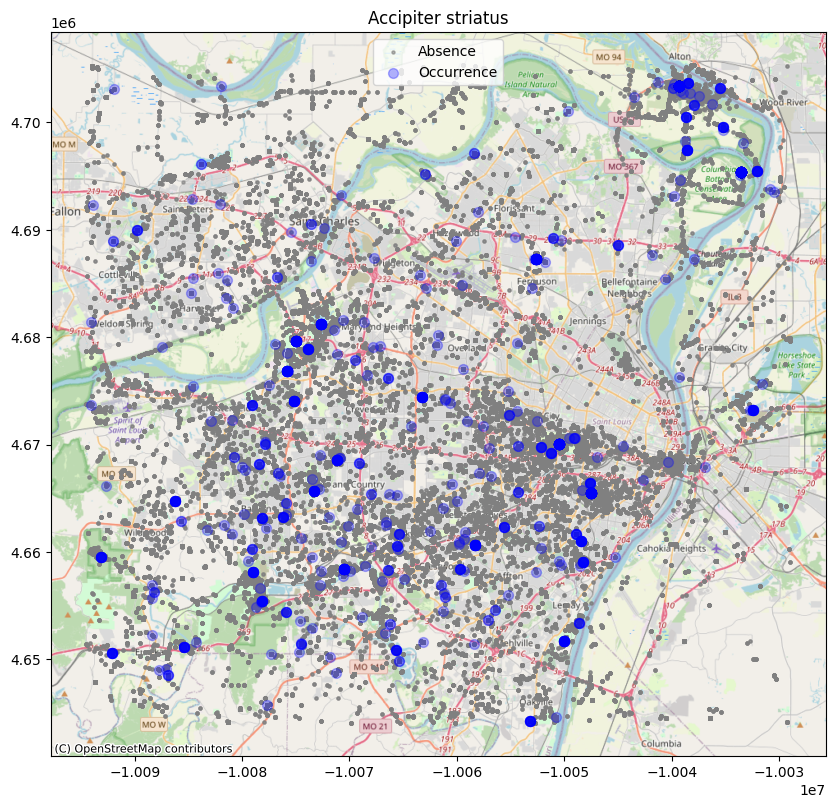

In [55]:
# Create maps for a few species

# Cardinals
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# Assume your DataFrame is named ebird_df
# Create a geometry column from longitude and latitude
species = 'Accipiter striatus' # 'Chaetura pelagica' # Accipiter striatus
geometry = [Point(xy) for xy in zip(ebird_df['longitude'], ebird_df['latitude'])]
gdf = gpd.GeoDataFrame(ebird_df, geometry=geometry, crs="EPSG:4326")

# Convert to Web Mercator for compatibility with OSM tiles
gdf = gdf.to_crs(epsg=3857)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot absence points (value 0) as small grey markers
gdf[gdf[species] == 0].plot(ax=ax, markersize=5, color='grey', label='Absence', alpha=0.6)

# Plot occurrence points (value 1) as larger blue markers
gdf[gdf[species] == 1].plot(ax=ax, markersize=50, color='blue', label='Occurrence', alpha=0.3)

# Add an OpenStreetMap background
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add a legend and display the plot
ax.legend()
plt.title(species)
plt.show()
